In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# IMPORTING DATASET

In [167]:
df = pd.read_csv('/content/perrin-freres-monthly-champagne.csv')

# VISUALIZATION

In [168]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


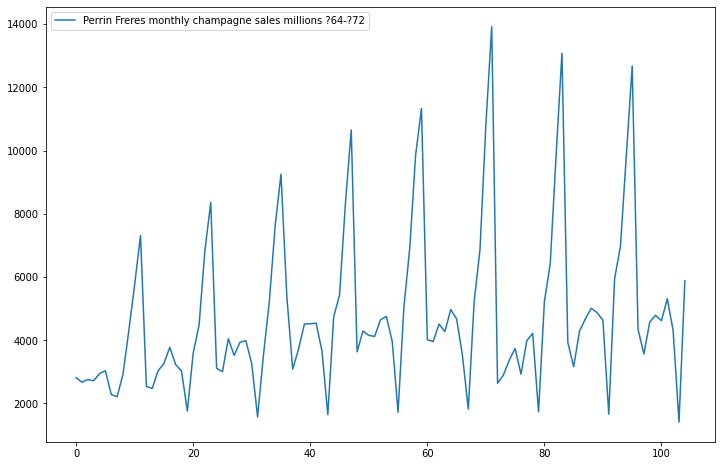

In [169]:
df.plot(figsize=(12,8))

In [170]:
df.columns = ['mnths','sales']

In [171]:
df = df.dropna().reset_index() 

In [172]:
df.index = pd.to_datetime(df['mnths'])

In [173]:
df

,index,mnths,sales
mnths,,,
1964-01-01,0,1964-01,2815.0
1964-02-01,1,1964-02,2672.0
1964-03-01,2,1964-03,2755.0
1964-04-01,3,1964-04,2721.0
1964-05-01,4,1964-05,2946.0
...,...,...,...
1972-05-01,100,1972-05,4618.0
1972-06-01,101,1972-06,5312.0
1972-07-01,102,1972-07,4298.0


In [174]:
df = df.drop(columns=['index','mnths'])

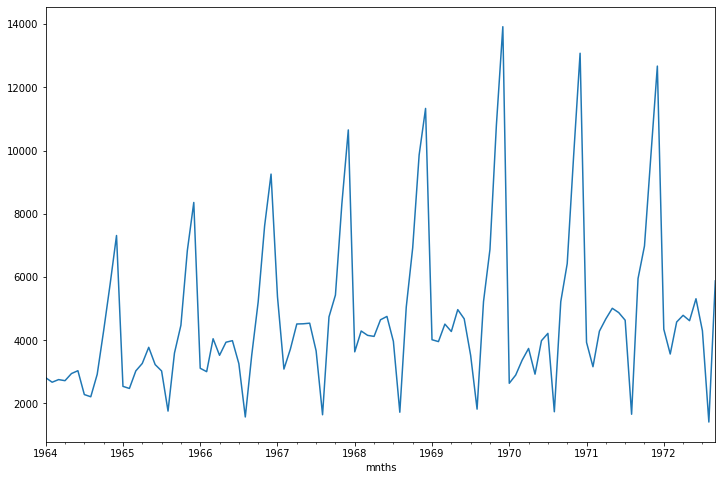

In [175]:
df['sales'].plot(figsize=(12,8))

# CHECKING FOR STATIONARITY USING ADFULLER TEST FOR A STATISTICAL STANDPOINT 

In [176]:
from statsmodels.tsa.stattools import adfuller

In [177]:
tstres = adfuller(df['sales'])

In [178]:
tstres

(-1.833593056327624,
 0.36391577166024447,
 11,
 93,
 {'1%': -3.502704609582561,
  '10%': -2.583636712914788,
  '5%': -2.8931578098779522},
 1478.4633060594724)

In [179]:
def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(color.GREEN+color.BOLD+label+' : '+str(value)+color.END)
    if result[1] <= 0.05:
        print(color.RED+color.BOLD+"strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary"+color.END)
    else:
        print(color.BLUE+color.BOLD+"weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary "+color.END)

In [180]:
adfuller_test(df['sales'])

ADF Test Statistic : -1.833593056327624
p-value : 0.36391577166024447
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [181]:
df['ssnl_diff_1'] = df['sales'] - df['sales'].shift(12)

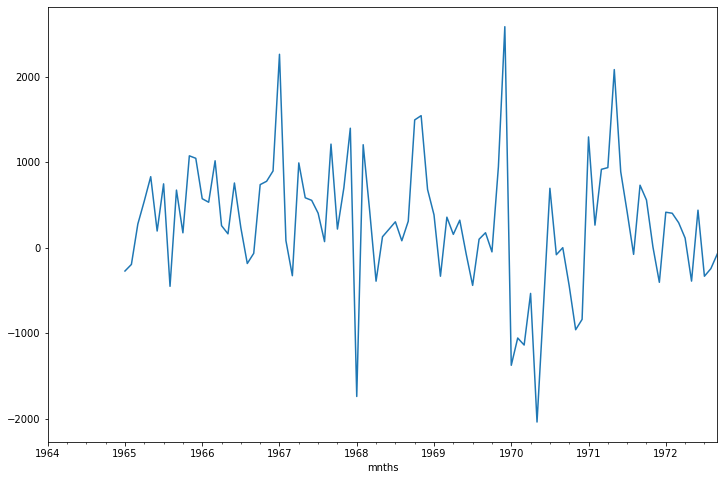

In [182]:
df['ssnl_diff_1'].plot(figsize=(12,8))

In [183]:
adfuller_test(df['ssnl_diff_1'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# DETERMINING ORDER OF MOVING AVERAGE(q) AND PARTIAL AUTO-CORRELATION(p)

In [184]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

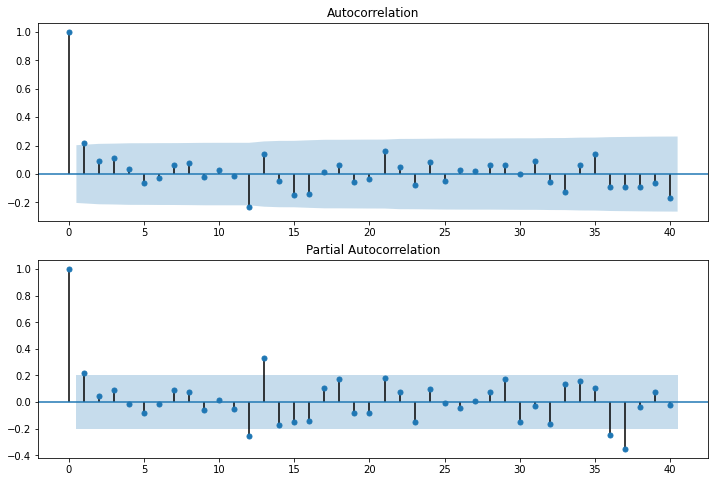

In [194]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['ssnl_diff_1'].iloc[12:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['ssnl_diff_1'].iloc[12:],lags=40,ax=ax2)

In [195]:
from statsmodels.tsa.arima_model import ARIMA

In [196]:
mod_p1_d1_q1 = ARIMA(endog=df['sales'],order=(1,1,1)).fit()
mod_p1_d1_q0 = ARIMA(endog=df['sales'],order=(1,1,0)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [197]:
mod_p1_d1_q1.forecast()

(array([5917.46912155]),
 array([2227.26227416]),
 array([[ 1552.11528007, 10282.82296303]]))

In [198]:
mod_p1_d1_q0.forecast()

(array([5499.19514648]),
 array([2627.30744448]),
 array([[  349.76717899, 10648.62311396]]))

# VISUALISTIC COMPARISON OF ALL FORECASTS

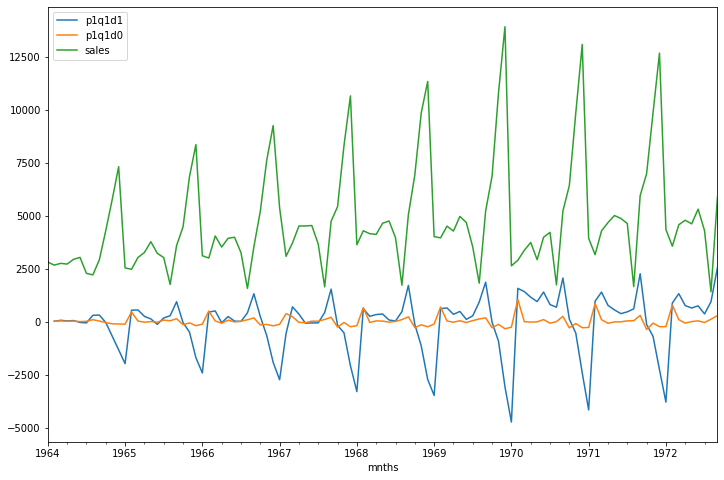

In [201]:
mod_p1_d1_q1.predict().plot(figsize=(12,8))
mod_p1_d1_q0.predict().plot(figsize=(12,8))
df['sales'].plot(figsize=(12,8))
plt.legend(['p1q1d1','p1q1d0','sales'])

In [233]:
def err(x,y):
    bias = x-y
    bias = bias.mean()
    mae = np.absolute(x-y)
    mae = mae.mean()
    mape = ((x-y)/x)*100
    mape = mape.mean()
    mse = (x-y)**2
    mse = mse.mean()
    a = [bias,mae,mape,mse]
    return a
clr = [color.RED,color.BLUE,color.GREEN,color.YELLOW]
errs = ['Bias','MAE','MAPE','MSE']

# COMPARISON OF ALL FORECASTS BASED ON ALL ERROR METRICS

In [234]:
for i in range(0,4):
  print(color.BOLD+clr[i]+errs[i]+' is '+str(err(df['sales'],mod_p1_d1_q1.predict())[i])+color.END)
print(color.DARKCYAN,'+-+-+-+-+-+-+-+-+-+',color.END)
for i in range(0,4):
  print(color.BOLD+clr[i]+errs[i]+' is '+str(err(df['sales'],mod_p1_d1_q0.predict())[i])+color.END)

Bias is 4838.211936320935
MAE is 4838.211936320935
MAPE is 97.66353894566022
MSE is 34406266.5648162
 +-+-+-+-+-+-+-+-+-+ 
Bias is 4749.709433835125
MAE is 4749.709433835125
MAPE is 98.28090629889901
MSE is 29609235.044894036


# ABOVE GIVEN MODELS ARE PRONE TO HIGH ERROR AND ALSO GIVEN THAT SEASONALITY IS OBSERVED, SO SARIMAX IS USED.

In [202]:
import statsmodels.api as sm

In [203]:
srmx = sm.tsa.statespace.SARIMAX(endog=df['sales'],order=(1,1,1),seasonal_order=(1,1,1,12)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [204]:
len(df['sales'])

105

In [205]:
df['frcst'] = srmx.predict()

# VISUALISTICALLY COMPARING SARIMAX PREDICTION AND ACTUAL SALES and FINDING THAT PREDICTION IS VERY WELL PLOTTED JUST UPON THE ACTUAL SALES.

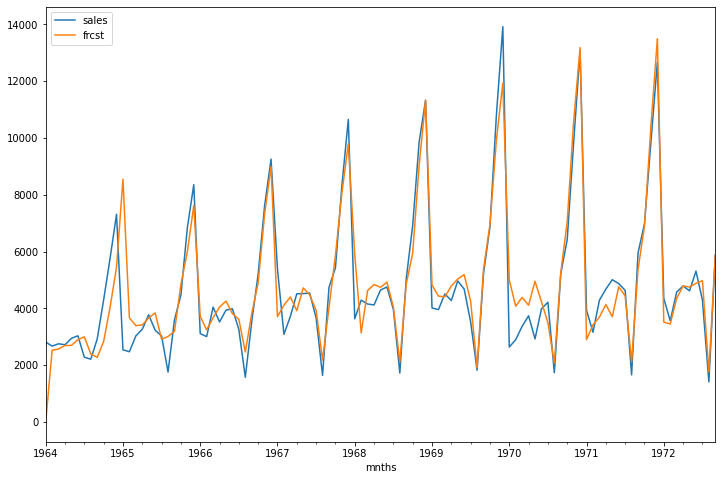

In [206]:
df[['sales','frcst']].plot(figsize=(12,8))

In [207]:
from pandas.tseries.offsets import DateOffset
fut_dts = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]

In [208]:
fut_dts_df = pd.DataFrame(index=fut_dts[1:],columns=df.columns)

In [209]:
fut_df = pd.concat([df,fut_dts_df])

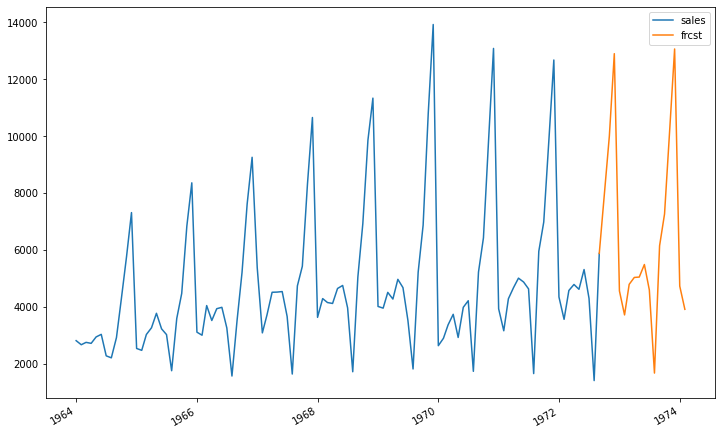

In [211]:
fut_df['frcst'] = srmx.predict(start=104,end=121,dynamic=True)
fut_df[['sales','frcst']].plot(figsize=(12,8))